# Conditional VAE for LHC Olympics 2020 dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense, Add, Activation, Concatenate
from tensorflow.keras.callbacks import History, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Concatenate, LeakyReLU, Reshape, Conv2DTranspose, Flatten, Conv2D
from tensorflow.keras.models import Model,Sequential

from utils import *

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

physical_devices = tf.config.experimental.list_physical_devices()
print("All available physical devices:", physical_devices)

# Select a GPU device for training
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    device = gpu_devices[0]
    tf.config.experimental.set_memory_growth(device, True)
    tf.config.experimental.set_visible_devices(device, 'GPU')
    print("Selected GPU device:", device)
else:
    print("No GPU devices found.")
    

All available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
No GPU devices found.


2023-03-30 12:34:56.407951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/22.5/math_libs/11.7/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/CUPTI/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/Debugger/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/nvvm/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/lib64:/opt/cray/pe/papi/7.0.0.1/lib64:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/libfabric/1.15.2.0/lib64
2023-03-30 12:34:56.407973: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your p

## Load training and test data

In [3]:
# outerdata_train = np.load("./data/preprocessed_data_6var/outerdata_train_6var.npy")
# outerdata_test = np.load("./data/preprocessed_data_6var/outerdata_test_6var.npy")
outerdata_train = np.load("./data/preprocessed_data_6var_more_training_data/outerdata_train_6var.npy")
outerdata_test = np.load("./data/preprocessed_data_6var_more_training_data/outerdata_test_6var.npy")

print(outerdata_test.shape)

# Num of feature stored in the data files
nFeat = 6
# Num of feature we want to use for training
input_dim = 6

outerdata_train = outerdata_train[outerdata_train[:,nFeat+1]==0]
outerdata_test = outerdata_test[outerdata_test[:,nFeat+1]==0]

data_train = outerdata_train[:,1:nFeat+1]
print('shape of data_train: ', data_train.shape)
data_test = outerdata_test[:,1:nFeat+1]
print('shape of data_test: ', data_test.shape)

data = np.concatenate((data_train, data_test), axis=0)
og_data = data
print('shape of data: ', data.shape)

cond_data_train = outerdata_train[:,0]
print('shape of cond_train', cond_data_train.shape)
cond_data_test = outerdata_test[:,0]
print('shape of cond_test', cond_data_test.shape)

cond_data = np.concatenate((cond_data_train, cond_data_test), axis=0)
og_cond_data = cond_data
print('shape of cond_data: ', cond_data.shape)

(28876, 8)
shape of data_train:  (849779, 6)
shape of data_test:  (28869, 6)
shape of data:  (878648, 6)
shape of cond_train (849779,)
shape of cond_test (28869,)
shape of cond_data:  (878648,)


## Plot training features

- Total 6 training features
- 1 conditional feature
- Training Features are scaled to such that they are in range [0,1]

In [4]:
feature_names = {
                0: "$m_{2}$",
                1: "$\Delta m = m_{1} - m_{2}$ ",
                2: "$\\tau_{21}^{J1}$",
                3: "$\\tau_{21}^{J2}$",
                4: "$\\tau_{32}^{J1}$",
                5: "$\\tau_{32}^{J2}$"
    
}

In [5]:
feature_labels = {
                0: "Min. Jet Mass",
                1: "Jet Mass Difference",
                2: "$\\tau_{21}$ Lead Jet",
                3: "$\\tau_{21}$ Sublead Jet",
                4: "$\\tau_{32}$ Lead Jet",
                5: "$\\tau_{32}$ Sublead Jet"
    
}

In [6]:
def plot_variables(data, density = False):
    
    plt.figure(figsize=(12,12))
    if density == False:
        plt.ylabel("Events")
    else:
        plt.ylabel("Normalized events")
    
    
    for i in range(input_dim):
        plt.subplot((input_dim+1)//2, 2, i+1)
        plt.xlabel(feature_names[i])
        plt.hist(data[:, i], bins=30, color = "darkblue",  histtype = "step", label = feature_labels[i], density = density)
        plt.legend()
        plt.yscale('log')


/tmp/ipykernel_5204/709068183.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot((input_dim+1)//2, 2, i+1)


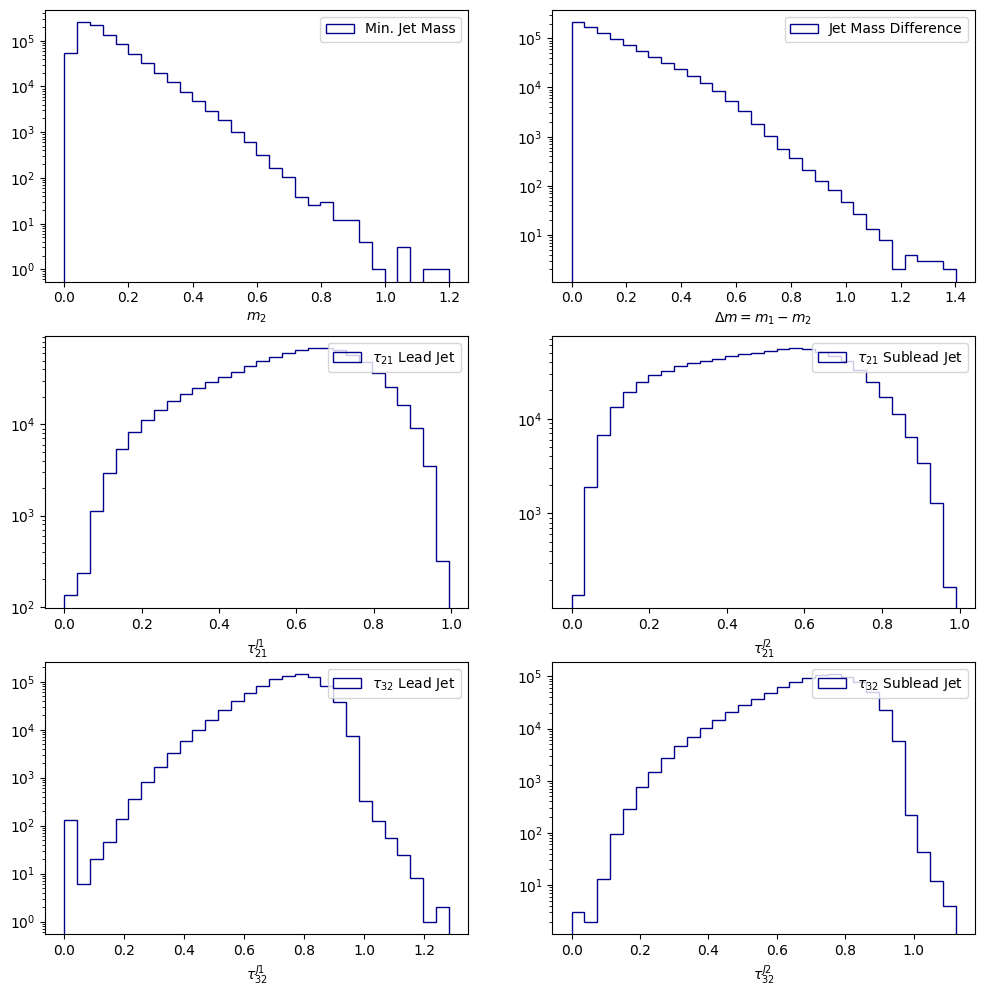

In [7]:
plot_variables(data)

### Feature scaling
<!-- Dividing each feature by the `abs(maximum)` value -->

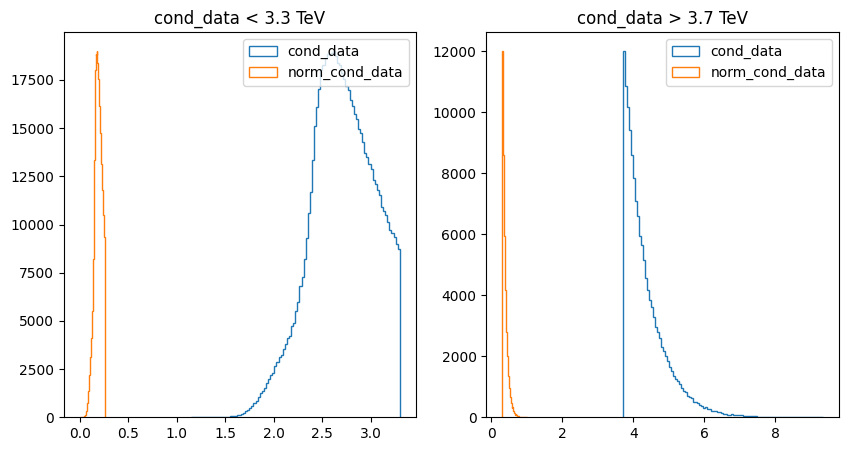

(710700,)
(139079,)


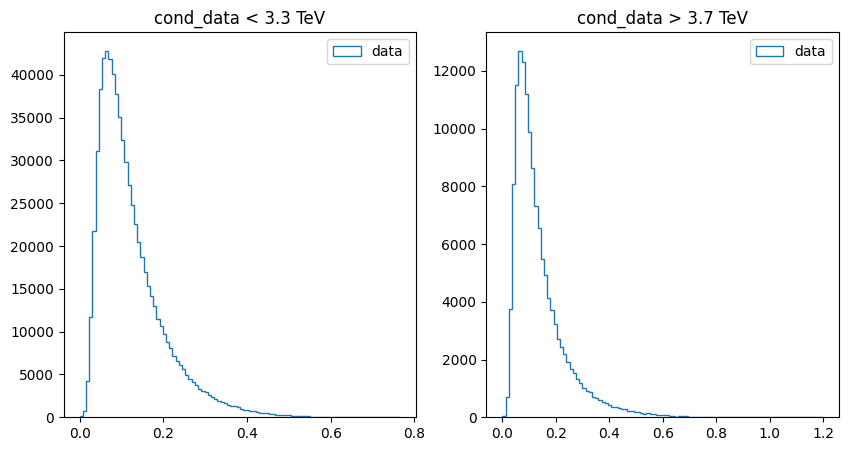

(710700,)
(139079,)


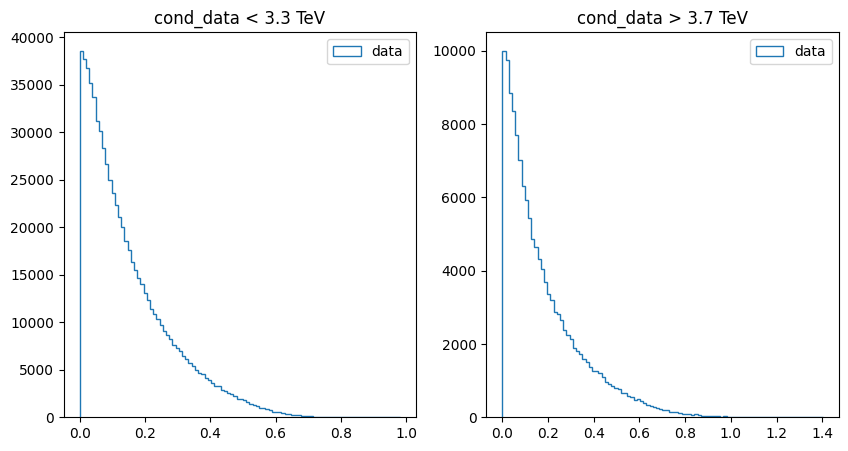

(710700,)
(139079,)


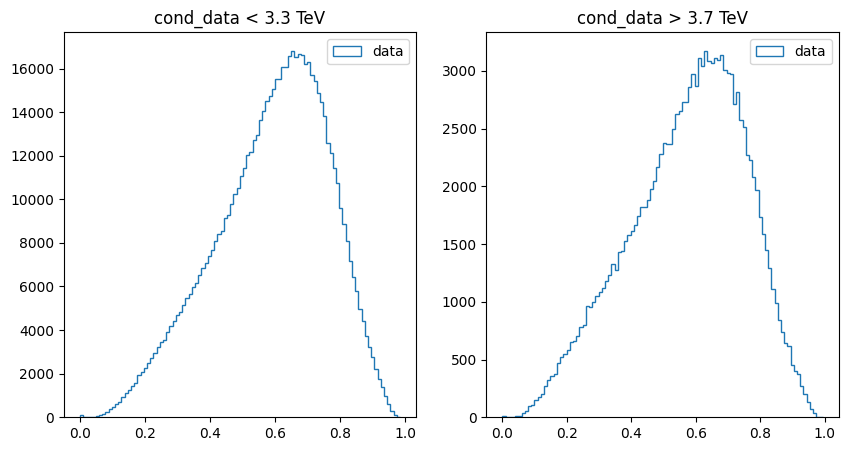

(710700,)
(139079,)


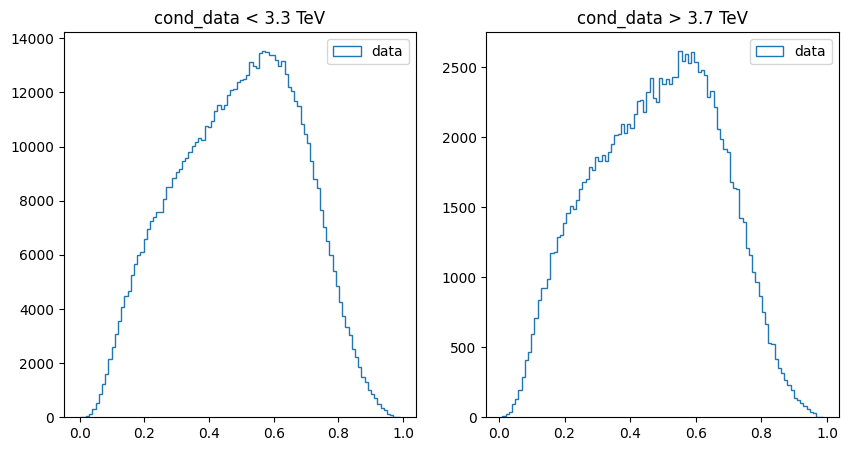

(710700,)
(139079,)


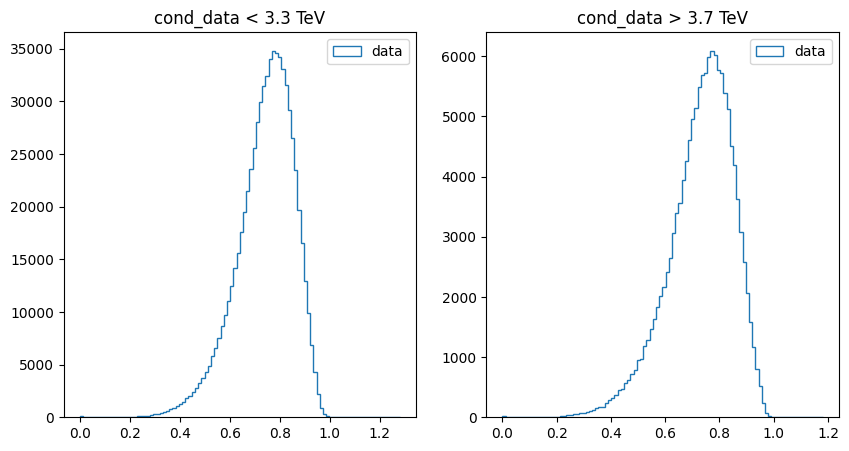

(710700,)
(139079,)


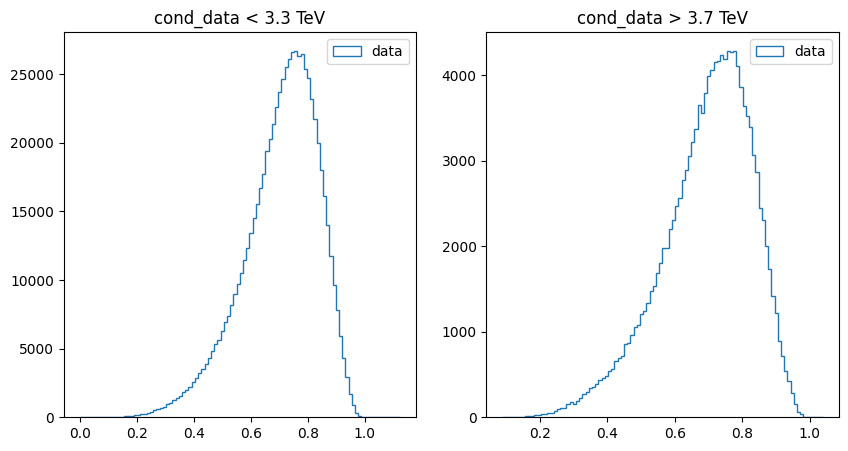

In [8]:
#cond_data = cond_data[cond_data >= 3.7]

#normalization
data, data_max, data_min = minmax_norm_data(data)
cond_data, cond_data_max, cond_data_min  = minmax_norm_cond_data(cond_data)
# data = logit_norm(data)
# cond_data = logit_norm(cond_data)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(og_cond_data[og_cond_data<3.3], bins=100, histtype='step', label="cond_data")
plt.hist(cond_data[cond_data<0.27], bins=100, histtype='step', label="norm_cond_data")
plt.title('cond_data < 3.3 TeV')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist(og_cond_data[og_cond_data>3.7], bins=100, histtype='step', label="cond_data")
plt.hist(cond_data[cond_data>0.27], bins=100, histtype='step', label="norm_cond_data")
plt.title('cond_data > 3.7 TeV')
plt.legend(loc='best')
plt.show()

#now we make the same plots as above for the each feature of normalized data, here is thec code:
for i in range(6):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.hist(data_train[cond_data_train<3.3,i], bins=100, histtype='step', label="data")
    print(data_train[cond_data_train<3.3,i].shape)
    # plt.hist(data[cond_data<0.27,i], bins=100, histtype='step', label="norm_data")
    plt.title('cond_data < 3.3 TeV')
    plt.legend(loc='best')
    plt.subplot(1,2,2)
    plt.hist(data_train[cond_data_train>3.7,i], bins=100, histtype='step', label="data")
    print(data_train[cond_data_train>3.7,i].shape)
    # plt.hist(data[cond_data>0.27,i], bins=100, histtype='step', label="norm_data")
    plt.title('cond_data > 3.7 TeV')
    plt.legend(loc='best')
    plt.show()


trainsize = outerdata_train.shape[0]

## Setting up for training

### Defining the train and test sets

In [9]:
data = data[:,0:input_dim]
print(data.shape)
data = np.reshape(data, (len(cond_data),input_dim))
print("Data Shape: ", np.shape(data))
x_train = data[:trainsize]
print(x_train.shape)
x_test = data[trainsize:]
y_train = cond_data[:trainsize]
y_test = cond_data[trainsize:]

# x_train = np.hstack([x_train,y_train.reshape(y_train.shape[0],1)])
# x_test = np.hstack([x_test,y_test.reshape(y_test.shape[0],1)])

image_size = x_train.shape[1]
original_dim = image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = np.reshape(y_train, [-1, 1])
y_test = np.reshape(y_test, [-1, 1])
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

(878648, 6)
Data Shape:  (878648, 6)
(849779, 6)


### Network parameters

In [27]:
# network parameters
batch_size = 1024
latent_dim = 6
epochs_1 = 512
epochs_2 = 120

In [11]:
#note: min-max norm is present in all version
folder_name = "cVAEz6_03-28-2023/"
comd = "mkdir -p "+"./outputs/models/"+folder_name
os.system(comd)


0

### Function for Gaussian Sampling in the VAE

In [5]:

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Define the Encoder 

In [6]:
def create_encoder(X,y):
    inputs = Concatenate()([X, y])
    x1 = Dense(32, activation='relu')(inputs)
    x2 = Dense(128, activation='relu')(x1)
    x3 = Dense(128, activation='relu')(x2)
    x4 = Dense(32, activation='relu')(x3)

    
    z_mean = Dense(latent_dim, name='z_mean')(x4)
    z_log_var = Dense(latent_dim, name='z_log_var')(x4)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    return Model([X, y], [z_mean, z_log_var, z], name='encoder')

### Define the Decoder

In [7]:
def create_decoder(z,y):
    latent_inputs = Concatenate()([z, y])
    x1 = Dense(32, activation='relu')(latent_inputs)
    x2 = Dense(128, activation='relu')(x1)
    x3 = Dense(128, activation='relu')(x2)
    x4 = Dense(32, activation='relu')(x3)

    outputs = Dense(input_dim, activation='linear')(x4)

    return Model([z, y], outputs, name='decoder')

In [12]:
# instantiate encoder model
encoder = create_encoder(Input(shape=(input_dim,)), Input(shape=(1,)))
encoder.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 7)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dens

In [13]:
# instantiate decoder model
decoder = create_decoder(Input(shape=(latent_dim,)), Input(shape=(1,)))
decoder.summary()


Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 7)            0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           256         concatenate_1[0][0]        

### Define the full VAE model

In [14]:
X_input = Input(shape=(input_dim,))
y_input = Input(shape=(1,))
z_mean, z_log_var, z = encoder([X_input,y_input])
outputs = decoder([z,y_input])

cvae = Model([X_input, y_input], outputs)

### Define the loss functions

In [15]:
def mse_loss_fn(x,  x_decoded_mean):
#     mse_loss = mse(x, x_decoded_mean) # objectives.mean_squared_error(x, x_decoded_mean)
    mse_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mse(x, x_decoded_mean)
            )
        )
    return mse_loss
    
def kl_loss_fn(x,  x_decoded_mean):
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return kl_loss
            

def vae_loss(x, x_decoded_mean):
#         mse_loss = mse(x, x_decoded_mean) # objectives.mean_squared_error(x, x_decoded_mean)
    mse_loss = mse_loss_fn(x, x_decoded_mean)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    beta=10**(-2)  #10**(-6)
    loss = K.mean((1-beta)*mse_loss + beta*kl_loss)
#         loss = K.mean(mse_loss + kl_loss)
    return loss


### Custom Saver function

In [16]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
           if (k == (iterations-1)):
               decoder.save("outputs/models/{}/model_cbvae_6var_m{}.h5".format(folder_name,epoch))
               encoder.save("outputs/models/{}/encoder_cbvae_6var_m{}.h5".format(folder_name,epoch))
decoderSaver = CustomSaver()

### Other network parameters and model compilation

In [25]:
learnrate = 0.001
iterations = 3
lr_limit = 0.001/(2**iterations)
history = History()
k=0

In [18]:
checkpointer = ModelCheckpoint(filepath='outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name), verbose=1, save_best_only=True)
opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
cvae.compile(optimizer=opt, loss=vae_loss)

cvae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 6), (None, 6 25516       input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 6)            25318       encoder[1][2]                

In [ ]:
#now we want to train the model and save the weights evry 100 epochs
for k in range(iterations):
    print("Iteration: "+str(k+1))
    cvae.fit([x_train, y_train], x_train,
            shuffle=True,
            epochs=epochs_1,
            batch_size=batch_size,
            validation_data=([x_test, y_test], x_test),
            callbacks=[history, decoderSaver, checkpointer])
    learnrate = learnrate/2
    if learnrate < lr_limit:
        learnrate = lr_limit
    opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    cvae.compile(optimizer=opt, loss=vae_loss)
    k+=1

#save the model
decoder.save("outputs/models/{}/model_cbvae_6var_m{}.h5".format(folder_name,epoch))
encoder.save("outputs/models/{}/encoder_cbvae_6var_m{}.h5".format(folder_name,epoch))


## Training loop

In [ ]:
list_loss = []
list_val_loss = [] 

while learnrate > lr_limit:
    # if k < 4:
    #     opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #     epochs = epochs_1
    # else:
    #     opt = SGD(learning_rate=learnrate, decay=1e-6, momentum=0.9, nesterov=True)
    #     epochs = epochs_2
    
    #Using only one opt
    opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    epochs = epochs_1
    
    cvae.compile(loss=vae_loss, optimizer=opt, metrics=[mse_loss_fn, kl_loss_fn])
    cvae.fit([x_train, y_train], x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, y_test], x_test),
            callbacks = [checkpointer, history, decoderSaver])
    cvae.load_weights('outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name))

    learnrate /= 2
    k=k+1

list_loss = np.append(list_loss, history.history['loss'])
list_val_loss = np.append(list_val_loss, history.history['val_loss'])

    
cvae.save_weights('outputs/models/%s/cbvae_LHCO2020_20d_e-6.h5'%(folder_name))



Train on 849779 samples, validate on 28869 samples


2023-03-28 17:50:35.671893: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 17:50:36.818510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36911 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


Epoch 1/1001


2023-03-28 17:50:40.946837: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


834560/849779 [============================>.] - ETA: 0s - loss: 130.4071 - mse_loss_fn: 130.7993 - kl_loss_fn: 91.5872
Epoch 00001: val_loss improved from inf to 1.98645, saving model to outputs/models/cVAEz6_03-28-2023_wLogit/cbvae_LHCO2020_20d_e-6.hdf5
849779/849779 [==============================] - 32s 38us/sample - loss: 128.1084 - mse_loss_fn: 128.4524 - kl_loss_fn: 91.9469 - val_loss: 1.9864 - val_mse_loss_fn: 0.8617 - val_kl_loss_fn: 111.9497


/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 2/1001
838656/849779 [============================>.] - ETA: 0s - loss: 1.8691 - mse_loss_fn: 0.8903 - kl_loss_fn: 98.7750
Epoch 00002: val_loss improved from 1.98645 to 1.39195, saving model to outputs/models/cVAEz6_03-28-2023_wLogit/cbvae_LHCO2020_20d_e-6.hdf5
849779/849779 [==============================] - 2s 2us/sample - loss: 1.8645 - mse_loss_fn: 0.8870 - kl_loss_fn: 98.6367 - val_loss: 1.3919 - val_mse_loss_fn: 0.5125 - val_kl_loss_fn: 87.2409
Epoch 3/1001
827392/849779 [============================>.] - ETA: 0s - loss: 1.3806 - mse_loss_fn: 0.5942 - kl_loss_fn: 79.2282
Epoch 00003: val_loss improved from 1.39195 to 0.99408, saving model to outputs/models/cVAEz6_03-28-2023_wLogit/cbvae_LHCO2020_20d_e-6.hdf5
849779/849779 [==============================] - 2s 2us/sample - loss: 1.3737 - mse_loss_fn: 0.5892 - kl_loss_fn: 79.0316 - val_loss: 0.9941 - val_mse_loss_fn: 0.2738 - val_kl_loss_fn: 71.7068
Epoch 4/1001
847872/849779 [============================>.] - ETA: 0s - loss

In [23]:
# Predict the mean and std from the training dataset
# latent mean
latent_mean = encoder.predict([x_train, y_train])[0]
# latent log variance --> variance --> std
latent_logvar = encoder.predict([x_train, y_train])[1]
latent_var = np.exp(latent_logvar)
latent_std = np.sqrt(latent_var)

# Save the latent mean and atd values
np.savetxt('outputs/models/%s/cbvae_LHCO2020_latent_mean_20d_e-6.csv'%folder_name, latent_mean)
np.savetxt('outputs/models/%s/cbvae_LHCO2020_latent_std_20d_e-6.csv'%folder_name, latent_std)

# Save the loss values
np.save("outputs/models/%s/cbvae_LHCO2020_val_loss.npy"%folder_name, list_val_loss)
np.save("outputs/models/%s/cbvae_LHCO2020_train_loss.npy"%folder_name, list_loss)

In [30]:
#this endocer and decoder is same as the ones used in above cell to save mean and std
folder = "/global/homes/a/agarabag/pscratch/GAEA_cp/outputs/models/cVAEz6_03-28-2023"
encoder = keras.models.load_model(folder+'/encoder_cbvae_6var_m512.h5')
decoder = keras.models.load_model(folder+'/model_cbvae_6var_m512.h5')

In [31]:
# Predict the mean and std from the training dataset

# latent mean
latent_mean = encoder.predict([x_train, y_train])[0]
# latent log variance --> variance --> std
latent_logvar = encoder.predict([x_train, y_train])[1]
latent_var = np.exp(latent_logvar)
latent_std = np.sqrt(latent_var)

# Save the latent mean and atd values
# np.savetxt('outputs/models/%s/cbvae_LHCO2020_latent_mean_m512_20d_e-6.csv'%folder_name, latent_mean)
# np.savetxt('outputs/models/%s/cbvae_LHCO2020_latent_std_m512_20d_e-6.csv'%folder_name, latent_std)

# Save the loss values
# np.save("outputs/models/%s/cbvae_LHCO2020_val_loss.npy"%folder_name, list_val_loss)
# np.save("outputs/models/%s/cbvae_LHCO2020_train_loss.npy"%folder_name, list_loss)

In [56]:
# list_val_loss

In [55]:
# history.history['loss']

(1539,)


ValueError: x and y must have same first dimension, but have shapes (1536,) and (1539,)

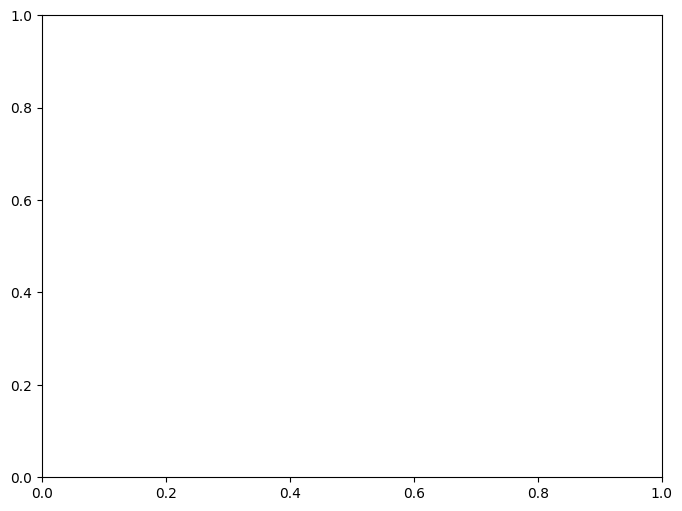

In [32]:
# plot loss function
list_val_loss = np.load("outputs/models/%s/cbvae_LHCO2020_val_loss.npy"%folder_name)
list_loss = np.load("outputs/models/%s/cbvae_LHCO2020_train_loss.npy"%folder_name)

print(list_loss.shape)
fig, ax = plt.subplots(1,1, figsize=(8,6))

plt.plot(np.arange(0,epochs_1*iterations), list_loss, label='training',c='blue',linewidth = 3)
plt.plot(np.arange(0,epochs_1*iterations), list_val_loss, label='validation',c='red',linewidth = 3)

plt.title("Loss vs. epoch", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
#log scale y axis
ax.set_yscale('log')
#set x limit
ax.set_xlim(0, 200)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()

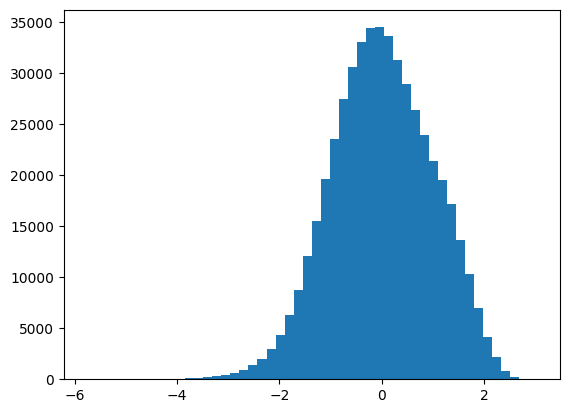

(499889, 6)


In [13]:
# Read the mean values
filename = 'outputs/models/%s/cbvae_LHCO2020_latent_mean_20d_e-6.csv'%folder_name
means_df = pd.read_csv(filename, sep=' ', header=None)
mean = means_df.values
plt.hist(mean[:,5], bins=50)
plt.show()

print(mean.shape)

# Read the std values
filename = 'outputs/models/%s/cbvae_LHCO2020_latent_std_20d_e-6.csv'%folder_name
stds_df = pd.read_csv(filename, sep=' ', header=None)
std = stds_df.values

z_samples = np.empty([cond_data.shape[0],latent_dim])

In [18]:
cond_data.shape
# plt.hist(cond_data, bins=50)

(878648,)

In [20]:
l=0
for i in range(0,cond_data.shape[0]):
    for j in range(0,latent_dim):
        z_samples[l,j] = np.random.normal(mean[i%trainsize,j], 0.05+std[i%trainsize,j])
    l=l+1
    
new_events = decoder.predict([z_samples, np.reshape(cond_data, [-1, 1])])

#reverse normalization
# new_events = expit_norm(new_events)
# new_events = rev_minmax_data(new_events, data_min, data_max)

# os.system("mkdir -p ./outputs/gen_dataset/%s/"%folder_name)
# np.save('outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_SB.npy'%folder_name, new_events)

IndexError: index 499889 is out of bounds for axis 0 with size 499889

In [49]:
print(z_samples.shape)
print(np.reshape(cond_data, [-1, 1]).shape)

(878648, 6)
(878648, 1)


-0.008223956836172224 1.0027739247862502


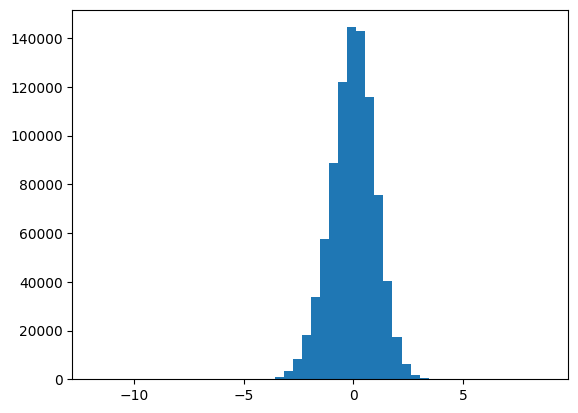

In [50]:
idx = 5 
plt.hist(z_samples[:, idx], bins=50)
print(np.mean(z_samples[:, idx]), np.std(z_samples[:, idx]))

In [14]:
file_gen_SB = 'outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_SB.npy'%folder_name
gen_SB = np.load(file_gen_SB)
# gen_SB = pd.read_csv(file_gen_SB, delimiter = ' ', header=None, index_col=False)
# gen_SB = gen_SB.to_numpy()
print("shape of gen_SR: ", gen_SB.shape)


shape of gen_SR:  (878648, 6)


In [15]:
# variables_names =  train_features
# vnames = train_features

plotting_ranges = [(0,0.8), (0,1), (0,1), (0,1), (0,1), (0,1)]

def fake_vs_real(gen_data,real_data,doLog,names):
    
    plt.figure(figsize=(20,15))
    colors = ["steelblue", "darkturquoise"]
    for p in range(0,nFeat):
        R = np.linspace(plotting_ranges[p][0],plotting_ranges[p][1],51)
        plt.subplot((nFeat+1)//2, 2, p+1)
        for rd in real_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="black", histtype='step', linewidth=2, label="MC Bkg", density=True)        
        for i,n in enumerate(gen_data): plt.hist(n[:,p], R, color=colors[i], histtype='stepfilled', alpha=0.5, linewidth=2, label="Generated Bkg %s"%names[i], density=True)
        # s_hist_y, s_hist_x, _ = plt.hist(sig_data[:,p], R, color="r", histtype='step', linewidth=3, label="Signal", density=True)
        plt.xlabel("%s"%feature_labels[p])
        if doLog == True: plt.yscale('log')
        plt.ylabel("Number of Events / bin")
        plt.legend(fontsize="large")
        ymax_b = np.max(b_hist_y)
        # ymax_s = np.max(s_hist_y)
        plt.ylim(0,ymax_b*1.5)
#     plt.savefig("fake_gen_compare_cbvae_6var_dynamicbeta.png")

In [16]:
cond_data.shape

(878648,)

/tmp/ipykernel_5204/3486223139.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,ymax_b*1.5)


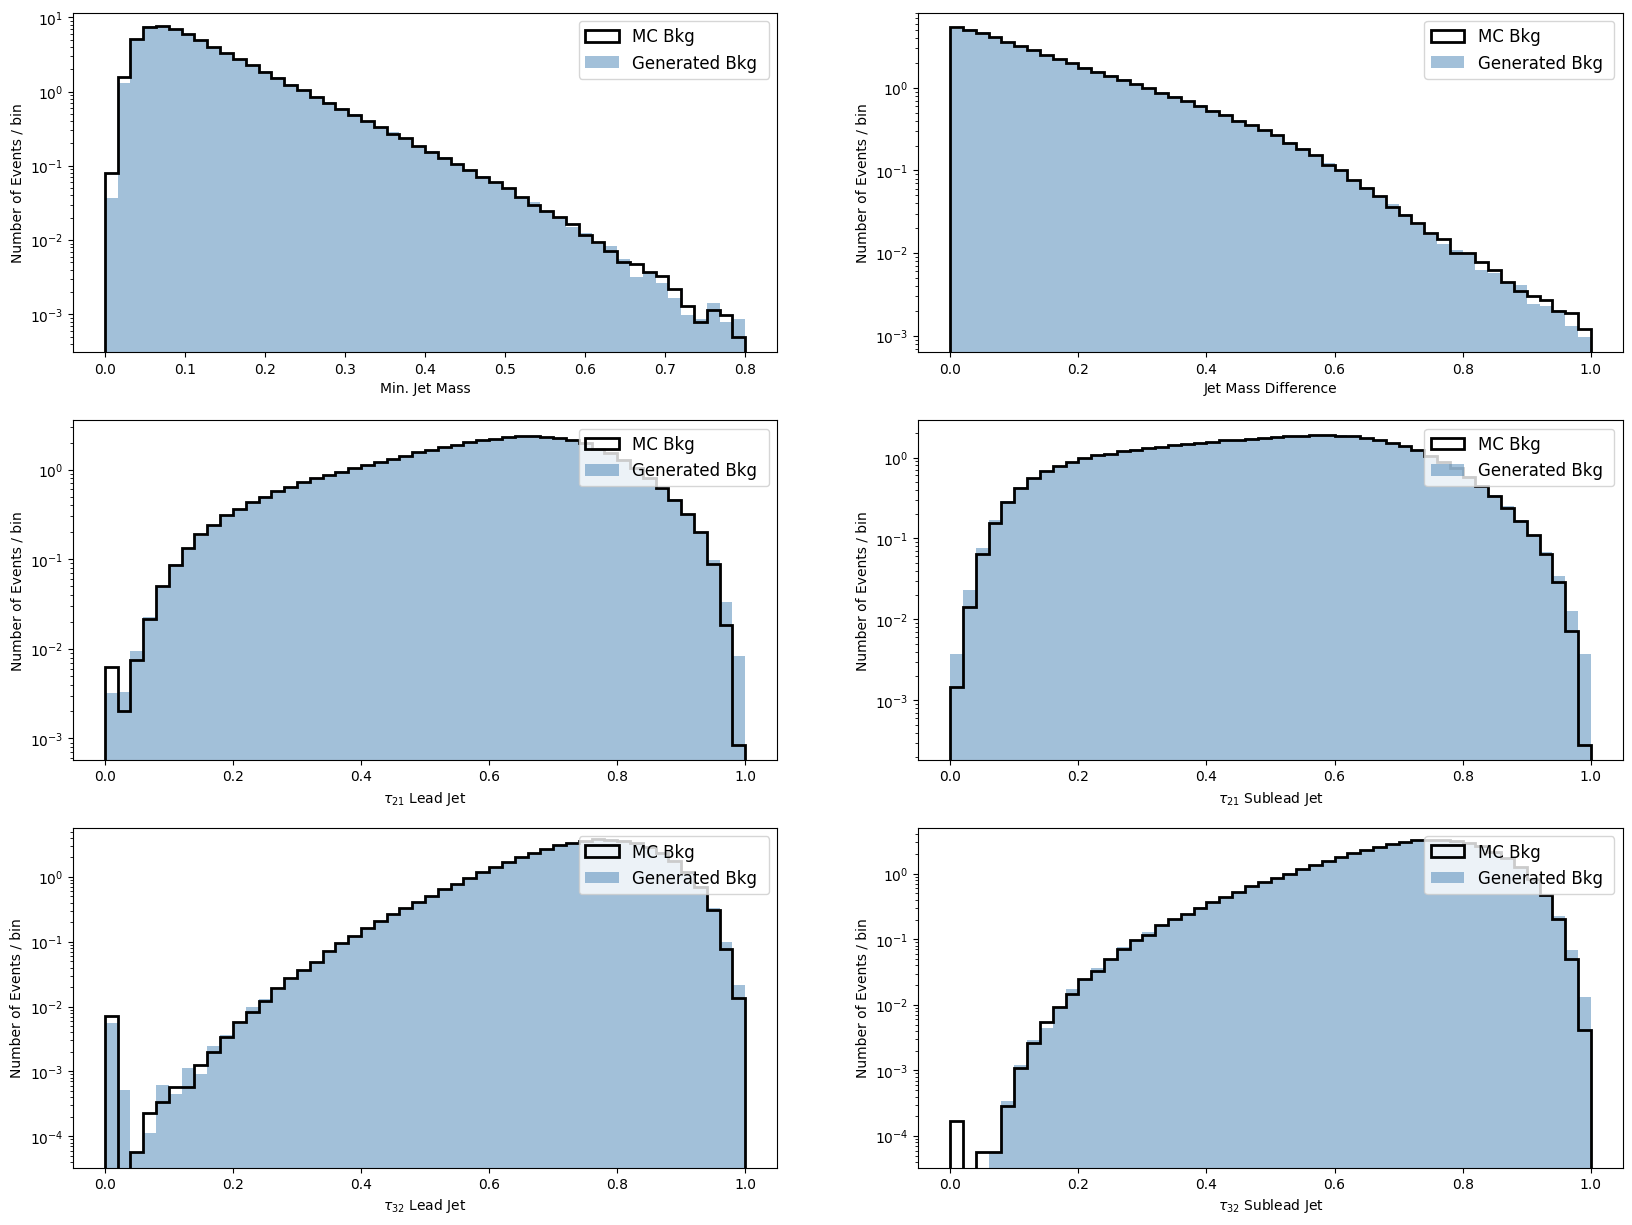

In [17]:
# un_norm_data = expit_norm(data)
un_norm_data = rev_minmax_data(data, data_min, data_max)
#fake_vs_real([gen_SB],[og_data],0,[""])
fake_vs_real([gen_SB],[un_norm_data],1,[""])

(40000, 8)
(99605, 6)
(99605,)
(99605, 6)
(878648, 6)
(878648, 1)


/tmp/ipykernel_5204/3486223139.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,ymax_b*1.5)


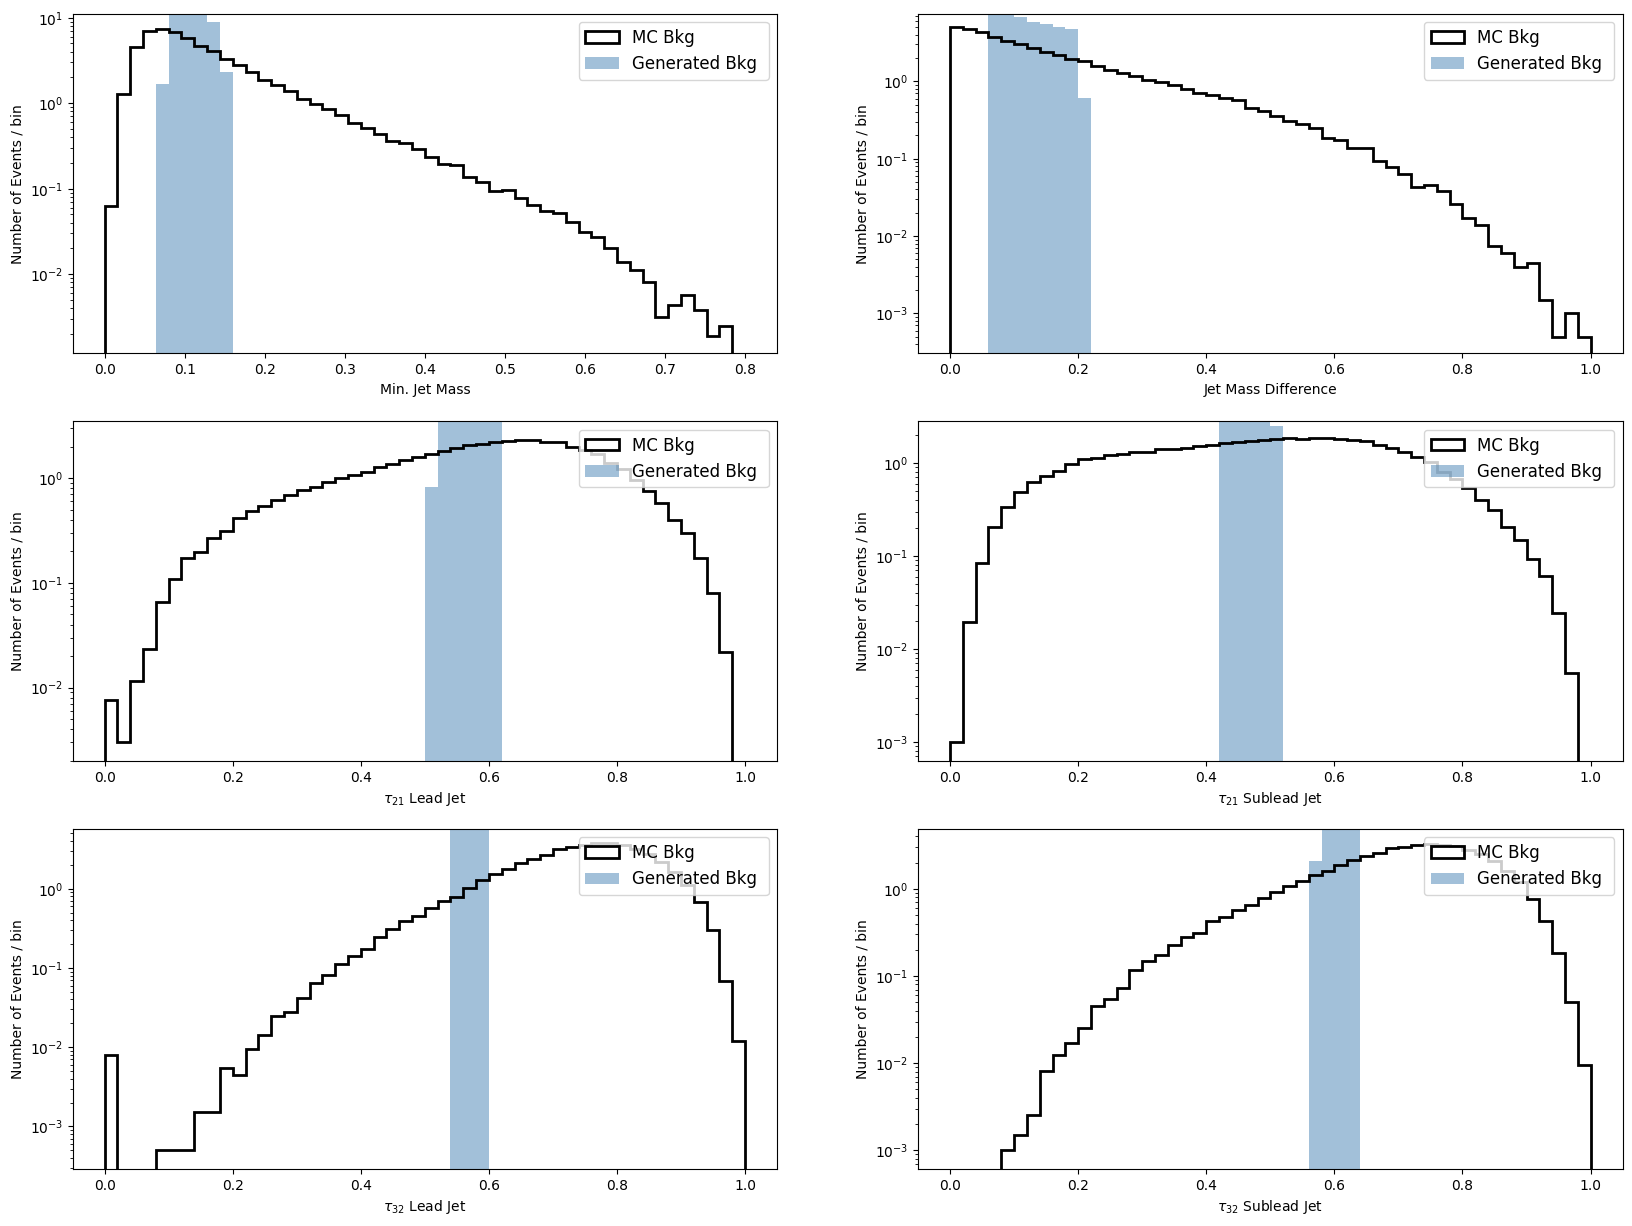

In [19]:
from sklearn.neighbors import KernelDensity

innerdata_train = np.load("./data/preprocessed_data_6var/innerdata_train_6var.npy")
innerdata_test = np.load("./data/preprocessed_data_6var/innerdata_test_6var.npy")

innerdata_train = innerdata_train[innerdata_train[:,nFeat+1]==0]
innerdata_test  = innerdata_test[innerdata_test[:,nFeat+1]==0]
print(innerdata_test.shape)

data_sr_train = innerdata_train[:,1:nFeat+1]
data_sr_test = innerdata_test[:,1:nFeat+1]
x_SR = np.concatenate((data_sr_train, data_sr_test), axis=0)
print(x_SR.shape)
x_SR, x_SR_max, x_SR_min = minmax_norm_data(x_SR)
# x_SR = logit_norm(x_SR)


y_innerdata_train = innerdata_train[:,0]
y_innerdata_test = innerdata_test[:,0]
y_SR = np.concatenate((y_innerdata_train, y_innerdata_test), axis=0)
y_SR, cond_data_SR_max, cond_data_SR_min = minmax_norm_cond_data(y_SR)
# y_SR = logit_norm(y_SR)
print(y_SR.shape)

KDE_bandwidth = 0.01
mjj_logit = quick_logit(y_SR)
y_SR = logit_transform_inverse(KernelDensity(
                  bandwidth=KDE_bandwidth, kernel='gaussian').fit(
                  mjj_logit.reshape(-1, 1)).sample(z_samples.shape[0]),
                                                   max(y_SR).item(),
                                                   min(y_SR).item())
# y_SR = KernelDensity(bandwidth=KDE_bandwidth, kernel='gaussian').fit(y_SR.reshape(-1, 1)).sample(z_samples.shape[0])

x_SR_train = x_SR[:trainsize]
image_size = x_SR_train.shape[1]
original_dim = image_size
x_SR_train = np.reshape(x_SR_train, [-1, original_dim])

print(x_SR_train.shape)
print(z_samples.shape)
print(np.reshape(y_SR, [-1, 1]).shape)

gen_SR = decoder.predict([z_samples, np.reshape(y_SR, [-1, 1])])
x_SR = rev_minmax_data(x_SR, x_SR_min, x_SR_max)

fake_vs_real([gen_SR],[x_SR],1,[""])